In [1]:
import sys
sys.path.append("../../src")
#sys.path.append("/home/rosa/Desktop/Master/S2/Special_Topics/Bram_code/src")
import os
import numpy as np
import pickle
from example_duffing import simulate_duffing, generate_duffing_data, get_duffing_data
from scipy.integrate import odeint
from autoencoder import full_network
from training import create_feed_dictionary
from sindy_utils import sindy_simulate, sindy_simulate_order2
#import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

2024-06-19 14:35:23.078636: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-19 14:35:23.080065: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-19 14:35:23.164184: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-19 14:35:23.505476: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-19 14:35:24.232310: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

## Generate the duffing data and plot it on 2D

In [2]:
sys_params = {'gamma': 0., 'alpha':-1., 'beta':1., 'delta': 0., 'omega': 0.}
# Time points
dt = 0.01 # 100000/100
T = 80
t = np.arange(0, T, 0.01) # changing T changes the plots!!

In [3]:
data_path = os.getcwd() + '/'
print(data_path)

save_name = 'duffing_2024_06_18_17_44_22_099508'
params = pickle.load(open(data_path + save_name + '_params.pkl', 'rb'))
params['save_name'] = data_path + save_name


/home/rosa/Desktop/Master/S2/Special_Topics/sindyautoencoders-master/examples/duffing/


In [4]:

autoencoder_network = full_network(params)


In [5]:

learning_rate = tf.compat.v1.placeholder(tf.float32, shape = [], name='learning_rate') # deprecated in TF 2.0
saver = tf.compat.v1.train.Saver(var_list=tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES))
tensorflow_run_tuple = ()
for key in autoencoder_network.keys():
    tensorflow_run_tuple += (autoencoder_network[key],)

## Single trajectory plots

In [6]:
# initial conds - if y<1, for some reason true duffing not plotted - problem in duffing_sim
z0 = np.array([[-1., 1.]])

test_data = generate_duffing_data(z0, t, params['input_dim'], linear=False, normalization=np.array([1/1,1/1]))
test_data['x'] = test_data['x'].reshape((-1,params['input_dim']))
test_data['dx'] = test_data['dx'].reshape((-1,params['input_dim']))
test_data['ddx'] = test_data['ddx'].reshape((-1,params['input_dim']))
test_data['z'] = test_data['z'].reshape((-1,params['latent_dim']))
test_data['dz'] = test_data['dz'].reshape((-1,params['latent_dim']))
test_data['ddz'] = test_data['ddz'].reshape((-1,params['latent_dim']))


points in high-dimensional dataset:  8


In [7]:
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

INFO:tensorflow:Restoring parameters from /home/rosa/Desktop/Master/S2/Special_Topics/sindyautoencoders-master/examples/duffing/duffing_2024_06_18_17_44_22_099508


2024-06-19 14:35:48.060430: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


In [8]:
true_coefficients = np.zeros(test_set_results['sindy_coefficients'].shape)

print(t.size)
# z_ic = test_set_results['z'][0]
# dz_ic = test_set_results['dz'][0]
z_ic = z0[:,0]
dz_ic = z0[:,1]

ics =np.array((2,1))
ics[0] = z_ic
ics[1] = dz_ic

duffing_sim, _, _ = simulate_duffing(ics, t, **sys_params)
z_sim = sindy_simulate_order2(z_ic, dz_ic, t, params['coefficient_mask']*test_set_results['sindy_coefficients'],
                       params['poly_order'], params['include_sine'])

8000


/tmp/ipykernel_19783/3675531363.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ics[0] = z_ic
/tmp/ipykernel_19783/3675531363.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ics[1] = dz_ic


In [9]:
test_set_results['z'] = test_set_results['z'].reshape((-1,params['latent_dim']))
test_set_results['z'].shape

(8000, 1)

In [10]:
test_set_results['z'] = test_set_results['z'].reshape((-1,params['latent_dim']))

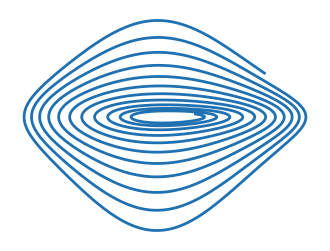

[-1.         -0.99000034 -0.98000262 ... -1.54907753 -1.54753752
 -1.54578165]


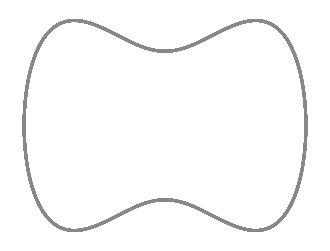

In [11]:
fig1 = plt.figure(figsize=(4,3))
plt.plot(z_sim[:,0], z_sim[:,1], color='#2071B1', linewidth=2)
plt.axis('off')
plt.savefig(f'figures/discovered-{save_name}.png', dpi=300)  # Save the figure
plt.show()  # Display the plot

fig1 = plt.figure(figsize=(4,3))
print(duffing_sim[:,0])
plt.plot(duffing_sim[:,0], duffing_sim[:,1], color='#888888', linewidth=2)
plt.xticks([])
plt.axis('off')
plt.savefig(f'figures/true-{save_name}.png', dpi=300)  # Save the figure
plt.show()  # Display the plot


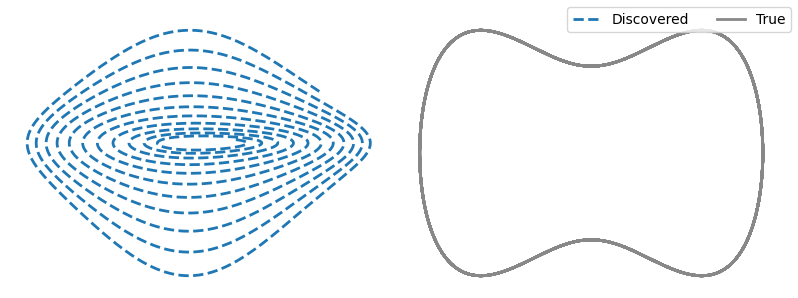

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))  # Create a figure with two subplots side by side

# Plot for the discovered system
line1 = axs[0].plot(z_sim[:, 0], z_sim[:, 1],'--', linewidth=2, label='Discovered')
axs[0].axis('off')  # Turn off the axis

# Plot for the real system
line2 = axs[1].plot(duffing_sim[:, 0], duffing_sim[:, 1], color='#888888',linewidth=2, label='True')
axs[1].axis('off')  # Turn off the axis

# Create a single legend for the whole figure using elements from both subplots
lines = line1 + line2
labels = [l.get_label() for l in lines]
fig.legend(lines, labels, ncols=2)  # Place the legend at the top center of the figure with two columns

plt.tight_layout()  # Adjust layout to make room for the legend
plt.savefig(f'figures/fig1-{save_name}.png', dpi=300)  # Save the figure
plt.show()  # Display the plot

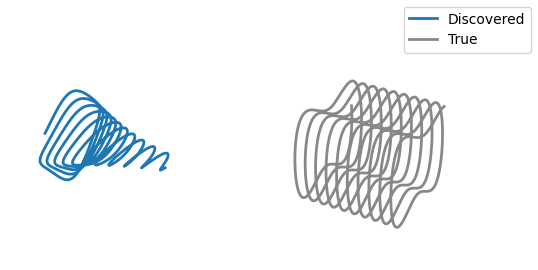

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3), subplot_kw={'projection': '3d'})  # Create a figure with two 3D subplots

# Discovered model plot
line1 = axs[0].plot(t, z_sim[:, 0], z_sim[:, 1], linewidth=2, label='Discovered')  # Add label for legend
axs[0].axis('off')  # Turn off the axis
axs[0].view_init(azim=120)  # Set the azimuth angle of the view

# Real model plot
line2 = axs[1].plot(t, duffing_sim[:, 0], duffing_sim[:, 1], color='#888888', linewidth=2, label='True')  # Add label for legend
axs[1].axis('off')  # Turn off the axis
axs[1].view_init(azim=120)  # Set the azimuth angle of the view

# Create a single legend for the whole figure using elements from both subplots
lines = line1 + line2
labels = [l.get_label() for l in lines]
fig.legend(lines, labels)  # Place the legend at the top center of the figure

# plt.tight_layout()  # Adjust layout to make room for the legend
plt.savefig(f'figures/fig2-{save_name}.png', dpi=300)  # Save the figure
plt.show()  # Display the plot


In [14]:
# fig, axs = plt.subplots(1, 2, figsize=(8, 3))  # Create a figure with two vertical subplots

# # Iterate over each subplot to plot the data
# for i in range(2):
#     axs[i].plot(t, duffing_sim[:, 0], color='#888888', linewidth=2)  # Plot Duffing model data in gray
#     axs[i].plot(t, z_sim[:, i], '--', linewidth=2)  # Plot discovered model data as dashed line
#     axs[i].axis('off')  # Turn off the axis
# plt.legend(['True', 'Discovered'], ncols=2)

# plt.savefig(f'figures/fig3-{save_name}.png')

In [15]:
coeffs = test_set_results['sindy_coefficients']
thresholded_coeffs = np.abs(coeffs) < params["coefficient_threshold"]
coeffs[thresholded_coeffs] = 0
coeff_strings = ["", "x", "dx", "x^2", "x*dx", "dx^2", "x^3", "x^2*dx", "x*dx^2", "dx^3", "sin(x)", "dsin(x)"]
formula = ""
for i in range(coeffs.size):
    if coeffs[i] != 0:
        formula += "{:.5f} ".format(coeffs[i][0])
        formula += coeff_strings[i]
        formula += " + "

formula[:-3]

'-0.72496  + -0.25870 x + 0.13813 dx + -0.04231 x^2 + 0.02371 x*dx + -0.06851 dx^2 + -0.00611 x^3 + -0.01408 x*dx^2'

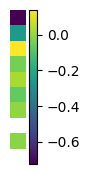

In [16]:
Xi_plot = (params['coefficient_mask']*test_set_results['sindy_coefficients'])
Xi_plot[Xi_plot==0] = np.inf
plt.figure(figsize=(1,2))
plt.imshow(Xi_plot, interpolation='none')
plt.xticks([])
plt.yticks([])
plt.axis('off')


# make colorbar that depends on the values of the matrix
# the values of clim are set to the min and max of coeffs
plt.clim(np.min(coeffs), np.max(coeffs))
plt.colorbar()

plt.savefig(f'figures/coeffbar-{save_name}.png', dpi=300)





## Test set analysis - in distribution

In [51]:
test_data = get_duffing_data(10, noise_strength=1e-6, sys_params=sys_params)

input_dim:  8
points in high-dimensional dataset:  8


In [52]:
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

INFO:tensorflow:Restoring parameters from /home/rosa/Desktop/Master/S2/Special_Topics/sindyautoencoders-master/examples/duffing/duffing_2024_06_09_15_37_53_728290


In [53]:
decoder_x_error = np.mean((test_data['x'] - test_set_results['x_decode'])**2)/np.mean(test_data['x']**2)
decoder_dx_error = np.mean((test_data['dx'] - test_set_results['dx_decode'])**2)/np.mean(test_data['dx']**2)
sindy_dz_error = np.mean((test_set_results['dz'] - test_set_results['dz_predict'])**2)/np.mean(test_set_results['dz']**2)

print('Decoder relative error: %f' % decoder_x_error)
print('Decoder relative SINDy error: %f' % decoder_dx_error)
print('SINDy reltive error, z: %f' % sindy_dz_error)

KeyError: 'dz_predict'

(10000, 1)
(10000, 1)
(1000,)


ValueError: x and y must have same first dimension, but have shapes (10000,) and (250,)

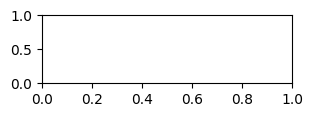

In [54]:
for ic in range(9):
    idxs = np.arange(ic*250,(ic+1)*250)

    print(test_set_results['z'].shape)
    print(test_set_results['dz'].shape)
    print(test_data['t'].shape)

    z_sim = sindy_simulate_order2(test_set_results['z'][250*ic], test_set_results['dz'][250*ic], test_data['t'],
                           params['coefficient_mask']*test_set_results['sindy_coefficients'],
                           params['poly_order'], params['include_sine'])

    col_idx = ic % 3

    if ic % 3 == 0:
        plt.figure(figsize=(11,3))
    for i in range(3):
        row_idx = i
        subplot_idx = 3*row_idx + col_idx + 1
        plt.subplot(3,3,subplot_idx)
        if i==0:
            plt.plot(t, test_set_results['z'][idxs,0], color='#888888', linewidth=2)
            plt.plot(t, z_sim[:,i], '--', linewidth=2)
        elif i==1:
            plt.plot(t, test_set_results['dz'][idxs,0], color='#888888', linewidth=2)
            plt.plot(t, z_sim[:,i], '--', linewidth=2)
        plt.xticks([])
        plt.yticks([])
#         plt.ylim(ylims[i])
        plt.axis('off')

## Test set analysis - out of distribution

In [53]:
inDist_ic_widths = np.array([36,48,41])
outDist_extra_width = np.array([18,24,20])
full_width = inDist_ic_widths + outDist_extra_width

t = np.arange(0, 5, .02)
n_ics = 100

i = 0
ics = np.zeros((n_ics,3))
while i < n_ics:

    ic = np.array([np.random.uniform(-full_width[0],full_width[0]),
                   np.random.uniform(-full_width[1],full_width[1]),
                   np.random.uniform(-full_width[2],full_width[2]) + 25])
    if ((ic[0] > -inDist_ic_widths[0]) and (ic[0] < inDist_ic_widths[0])) \
        and ((ic[1] > -inDist_ic_widths[1]) and (ic[1] < inDist_ic_widths[1])) \
        and ((ic[2] > 25-inDist_ic_widths[2]) and (ic[2] < 25+inDist_ic_widths[2])):
        continue
    else:
        ics[i] = ic
        i += 1

noise_strength = 1e-6

# training test_data
test_data = generate_duffing_data(ics, t, params['input_dim'], linear=False, normalization=np.array([1/1,1/1,1/1]))
test_data['x'] = test_data['x'].reshape((-1,params['input_dim']))
test_data['x'] += noise_strength*np.random.normal(size=test_data['x'].shape)
test_data['dx'] = test_data['dx'].reshape((-1,params['input_dim']))
test_data['dx'] += noise_strength*np.random.normal(size=test_data['dx'].shape)

RuntimeError: The size of the array returned by func (2) does not match the size of y0 (3).

In [54]:
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

INFO:tensorflow:Restoring parameters from /home/rosa/Desktop/Master/S2/Special_Topics/sindyautoencoders-master/examples/duffing/duffing_2024_06_09_15_37_53_728290


In [55]:
decoder_x_error = np.mean((test_data['x'] - test_set_results['x_decode'])**2)/np.mean(test_data['x']**2)
decoder_dx_error = np.mean((test_data['dx'] - test_set_results['dx_decode'])**2)/np.mean(test_data['dx']**2)
sindy_dz_error = np.mean((test_set_results['dz'] - test_set_results['dz_predict'])**2)/np.mean(test_set_results['dz']**2)

print('Decoder relative error: %f' % decoder_x_error)
print('Decoder relative SINDy error: %f' % decoder_dx_error)
print('SINDy reltive error, z: %f' % sindy_dz_error)

KeyError: 'dz_predict'

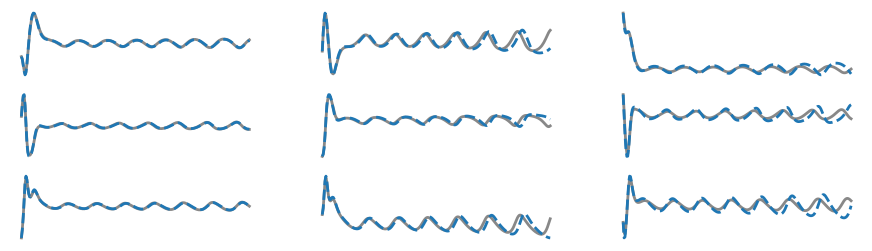

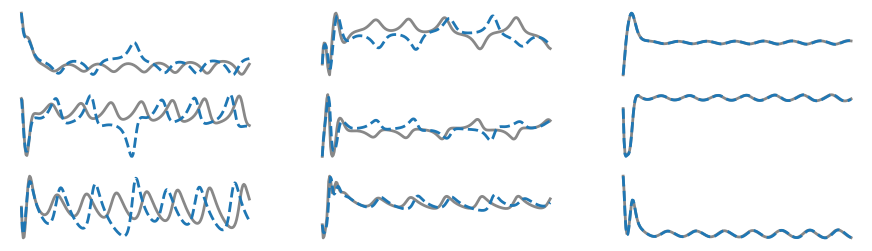

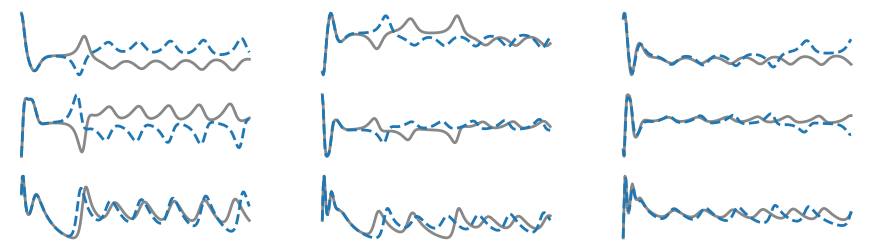

In [19]:
for ic in range(9):
    idxs = np.arange(ic*250,(ic+1)*250)

    z_sim = sindy_simulate(test_set_results['z'][250*ic], test_data['t'],
                           params['coefficient_mask']*test_set_results['sindy_coefficients'],
                           params['poly_order'], params['include_sine'])

    col_idx = ic % 3

    if ic % 3 == 0:
        plt.figure(figsize=(11,3))
    for i in range(3):
        row_idx = i
        subplot_idx = 3*row_idx + col_idx + 1
        plt.subplot(3,3,subplot_idx)
        plt.plot(test_data['t'], test_set_results['z'][idxs,i], color='#888888', linewidth=2)
        plt.plot(test_data['t'], z_sim[:,i], '--', linewidth=2)
        plt.xticks([])
        plt.yticks([])
#         plt.ylim(ylims[i])
        plt.axis('off')